Скачать набор данных creditcard.csv с https://www.kaggle.com/mlg-ulb/creditcardfraud, в котором: Time – время транзакции, V1-V28 – признаки, Amount – количество, Class – класс транзакции: мошенническая (Class=1) и легальная (Class=0).

Используя train_test_split(…, test_size=0.3, stratify=df.Class) разбейте выборку на тренировочное и тестовое множества так, чтобы тестовая выборка составляла 30% от всей выборки и в тестовой выборке пропорция мошеннических и легальных транзакций была такой же как и в основной выборке (stratify).

При решении задачи классификации транзакций на мошеннические и легальные необходимо максимизировать метрику macro f1 на тестовой выборке.

Задание 1. Применить методы бэггинга, случайного леса, LightGBM

Задание 2. Оптимизировать/настроить указанные (или любые другие) методы машинного обучения (не глубокого) для максимизации значения macro f1 на тестовой выборке. Для метода, обеспечившего максимум  macro f1, построить матрицу ошибок.

Задание 3. Применить и настроить/оптимизировать CatBoost для решения рассматриваемой задачи классификации.

# Задание 1. Применить методы бэггинга, случайного леса, LightGBM

Начнем с загрузки и предварительной обработки данных:

Разбиваем выборку на тренировочное и тестовое множества так, чтобы тестовая выборка составляла 30% от всей выборки и в тестовой выборке пропорция мошеннических и легальных транзакций была такой же как и в основной выборке (stratify).

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("archive/creditcard.csv")

# drop info in X about the target column
X = df.drop("Class", axis=1)
# y - target column
y = df["Class"]

# split arrays into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [82]:
df.shape

(284807, 31)

При решении задачи классификации транзакций на мошеннические и легальные необходимо максимизировать метрику macro f1 на тестовой выборке.

macro: Рассчитайте показатели для каждого ярлыка и найдите их невзвешенное среднее значение. При этом не учитывается дисбаланс меток.

бэггинг - n_estimator, default=10 - Количество алгоритмов в ансамбле. Сменила на 20 - дольше, результат тот же

случайный лес - n_estimatorsint, default=10 - Количество деревьев в ансамбле.

Light Gradient Boosted Machine (LightGBM). эффективной реализацией алгоритма градиентного бустинга. n_estimatorsint, default=10 - Количество деревьев в ансамбле.

random_state – начальное значение для генерации случайных чисел (по дефолту его нет, для 
воспроизведения результатов нужно указать любое число типа int).


In [2]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from lightgbm import LGBMClassifier

In [86]:
# создание и обучение модели BaggingClassifier
bag_clf = BaggingClassifier(random_state=42)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
f1_bag = f1_score(y_test, y_pred_bag, average='macro')

# создание и обучение модели RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

# создание и обучение модели LGBMClassifier
lgbm_clf = LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train, y_train)
y_pred_lgbm = lgbm_clf.predict(X_test)
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='macro')

In [87]:
print("BaggingClassifier f1-score: {:.7f}".format(f1_bag))
print("RandomForestClassifier f1-score: {:.7f}".format(f1_rf))
print("LGBMClassifier f1-score: {:.7f}".format(f1_lgbm))

BaggingClassifier f1-score: 0.9044336
RandomForestClassifier f1-score: 0.9225214
LGBMClassifier f1-score: 0.6256525


# Задание 2. Оптимизировать/настроить указанные (или любые другие) методы машинного обучения (не глубокого) для максимизации значения macro f1 на тестовой выборке. Для метода, обеспечившего максимум  macro f1, построить матрицу ошибок.

Для оптимизации и настройки методов машинного обучения можно использовать GridSearchCV из библиотеки sklearn. Для каждой модели определим набор параметров, которые будут изменяться, и их диапазоны.

max_samples – int or float, default=1.0. Количество экземпляров 
из X на обучение каждого алгоритма. int == указанное 
количество.float == max_samples * X.shape[0] samples.

max_depth – максимальная глубина дерева


In [92]:
from sklearn.model_selection import GridSearchCV

# Задаем словарь для перебора значений параметров
# определение параметров для BaggingClassifier
param_grid_bag = {'n_estimators': [10, 50, 100], 'max_samples': [0.5, 1.0]}

# определение параметров для RandomForestClassifier
param_grid_rf = {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, None]}

# определение параметров для LGBMClassifier
param_grid_lgbm = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5], 'max_depth': [3, 5, 10]}

Затем создаем экземпляры GridSearchCV для каждой модели, передавая ей определенные ранее параметры. Запускаем обучение на обучающей выборке и находим лучшую комбинацию параметров с помощью кросс-валидации. Затем выводим результаты и метрику macro f1 на тестовой выборке для каждой модели.

param_grid – dict or list of dictionaries. Словарь партеров со значениями для перебора. 

scoring – str, callable, list, tuple or dict, default=None. Оценка модели 

n_jobs – int, default=None. Количество задействованных ядер процессора. None==1, -1==все 
ядра процесора.

cv – int, cross-validation generator or an iterable, default=None.

cross-validation splitting strategy. None == 5-fold cross validation, int == точное 
количество фолдов (Stratified)KFold, есть и другие 

In [35]:
# оптимизация параметров для BaggingClassifier
bag_clf = BaggingClassifier(random_state=42)
grid_bag = GridSearchCV(bag_clf, param_grid_bag, cv=5, scoring='f1_macro', n_jobs=-1)
grid_bag.fit(X_train, y_train)
# для предсказания используется классификатор с наилучшим recall
best_bag_clf = grid_bag.best_estimator_
y_pred_bag = best_bag_clf.predict(X_test)
f1_bag = f1_score(y_test, y_pred_bag, average='macro')

# оптимизация параметров для RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf_clf = grid_rf.best_estimator_
y_pred_rf = best_rf_clf.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

# оптимизация параметров для LGBMClassifier
lgbm_clf = LGBMClassifier(random_state=42)
grid_lgbm = GridSearchCV(lgbm_clf, param_grid_lgbm, cv=5, scoring='f1_macro', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)
best_lgbm_clf = grid_lgbm.best_estimator_
y_pred_lgbm = best_lgbm_clf.predict(X_test)
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='macro')

Выводим результаты для каждой модели:

In [36]:
# результаты после оптимизации параметров
print("BaggingClassifier f1-score: {:.7f}".format(f1_bag))
print("RandomForestClassifier f1-score: {:.7f}".format(f1_rf))
print("LGBMClassifier f1-score: {:.7f}".format(f1_lgbm))

BaggingClassifier f1-score: 0.9189887
RandomForestClassifier f1-score: 0.9241252
LGBMClassifier f1-score: 0.8967319


Предыдущие результаты:

BaggingClassifier f1-score: 0.9044336 <br>
RandomForestClassifier f1-score: 0.9225214 <br>
LGBMClassifier f1-score: 0.6377802

Метод RF обеспечил максимум метрики macro f1, поэтому построим для него матрицу ошибок на тестовой выборке:

In [39]:
from sklearn.metrics import confusion_matrix

# Получение прогнозов на тестовой выборке
y_pred = rf_clf.predict(X_test)

# Вычисление матрицы ошибок
conf_mat = confusion_matrix(y_test, y_pred)

print('Матрица ошибок на тестовой выборке:')
print(conf_mat)

Матрица ошибок на тестовой выборке:
[[85290     5]
 [   36   112]]


Матрица ошибок показывает, что на тестовой выборке было 85295 легальных транзакций и 149 мошеннических. Из них модель правильно определила 112 мошеннических транзакций, но ошиблась в 36 случаях, отнесла легальные транзакции к мошенническим. В то же время, модель правильно определила 85290 легальных транзакций, но ошиблась в 5 случаях, отнесла мошеннические транзакции к легальным.

Несмотря на то, что модель справилась с задачей классификации достаточно хорошо, наблюдаются ложные срабатывания, что может привести к дополнительным затратам на проверку транзакций, которые были неверно отнесены к мошенническим.

мошенническая (Class=1) и легальная (Class=0)

Beautiful visualization:

Text(0.5, 1.0, 'Test')

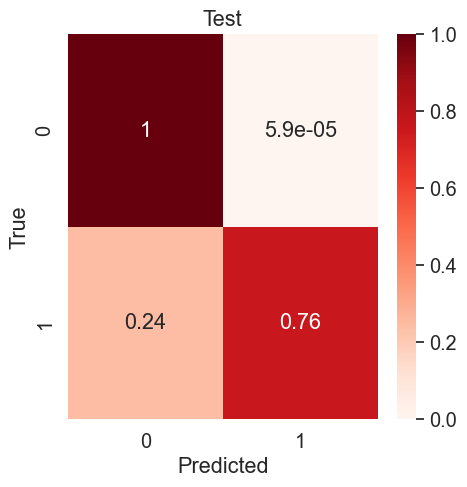

In [96]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


preds_test = rf_clf.predict(X_test)
cm_train = confusion_matrix(y_test, preds_test).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(5, 5))
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test")

# Задание 3. Применить и настроить/оптимизировать CatBoost для решения рассматриваемой задачи классификации.

Catboost работает только с пулами, которые являются внутренним форматом данных. Если вы передадите ему массив numpy, он сначала неявно преобразует его в пул, не сообщая вам об этом. Если вам нужно применить много формул к одному набору данных, использование пула резко повысит производительность (например, в 10 раз), потому что вы будете каждый раз пропускать шаг преобразования.

In [3]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import CatBoostClassifier, Pool

Настройка параметров вручную:

In [9]:
test_data = catboost_pool = Pool(X_train, y_train)
model = CatBoostClassifier(iterations=100,
                depth=6,
                learning_rate=0.1,
                loss_function='Logloss',
                verbose=False)
# train the model
model.fit(X_train, y_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Оптимизация с помощью GridSearchCV:

In [93]:
# Оптимизация гиперпараметров
params = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 1],
    'iterations': [30, 50, 100]
}

model_2 = GridSearchCV(
    CatBoostClassifier(verbose=False), 
    params, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

model_2.fit(X_train, y_train, plot=True)


c:\Users\mikko\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.65817705 0.92146331 0.92791342 0.8466565  0.92493935 0.92860566
 0.91545473 0.92495902 0.93793829        nan        nan 0.92392853
 0.87988081 0.92798608 0.92820509        nan        nan 0.92848306
 0.85956907 0.93006166 0.92229619 0.89049152 0.93161456 0.92535109
 0.91626961 0.93386161 0.9280549 ]
  warnings.warn(


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021F8491AAF0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.1, 1]},
             scoring='f1_macro')

1 HANDLE:

In [10]:
from sklearn.metrics import classification_report

# Оценка производительности на тестовой выборке
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
f1_score(y_test, y_pred, average='macro')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.92      0.77      0.84       148

    accuracy                           1.00     85443
   macro avg       0.96      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443



0.9189887010168809

2 GridSearchCV:

In [94]:
from sklearn.metrics import classification_report

# Оценка производительности на тестовой выборке
y_pred_2 = model_2.predict(X_test)
print(classification_report(y_test, y_pred_2))
f1_score(y_test, y_pred_2, average='macro')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.74      0.83       148

    accuracy                           1.00     85443
   macro avg       0.97      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443



0.9149624683992869

Построить матрицу ошибок:

In [11]:
from sklearn.metrics import confusion_matrix

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[85285    10]
 [   34   114]]


Text(0.5, 1.0, 'Test')

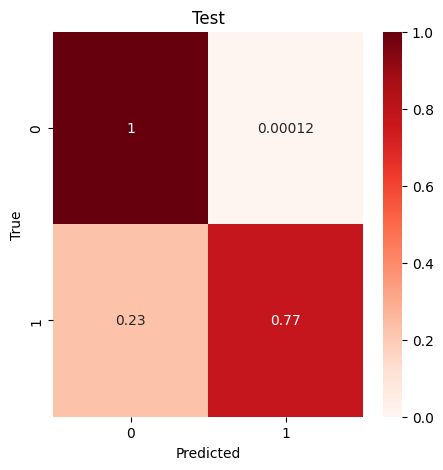

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


preds_test = model.predict(X_test)
cm_train = confusion_matrix(y_test, preds_test).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(5, 5))
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test")

In [109]:
# Оптимизация гиперпараметров
params = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 1],
    'iterations': [30, 50, 100],
    'l2_leaf_reg': [1, 3, 5]
}

model = CatBoostClassifier()

grid_search_result = model.grid_search(params, X=X_train, y = y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6519268	test: 0.6520124	best: 0.6520124 (0)	total: 69.8ms	remaining: 2.02s
1:	learn: 0.6174257	test: 0.6174768	best: 0.6174768 (1)	total: 134ms	remaining: 1.88s
2:	learn: 0.5828562	test: 0.5828875	best: 0.5828875 (2)	total: 204ms	remaining: 1.83s
3:	learn: 0.5494301	test: 0.5494473	best: 0.5494473 (3)	total: 263ms	remaining: 1.71s
4:	learn: 0.5209428	test: 0.5209886	best: 0.5209886 (4)	total: 371ms	remaining: 1.85s
5:	learn: 0.4911547	test: 0.4912043	best: 0.4912043 (5)	total: 447ms	remaining: 1.79s
6:	learn: 0.4647267	test: 0.4647753	best: 0.4647753 (6)	total: 560ms	remaining: 1.84s
7:	learn: 0.4372591	test: 0.4373003	best: 0.4373003 (7)	total: 629ms	remaining: 1.73s
8:	learn: 0.4105902	test: 0.4106263	best: 0.4106263 (8)	total: 721ms	remaining: 1.68s
9:	learn: 0.3844044	test: 0.3844553	best: 0.3844553 (9)	total: 766ms	remaining: 1.53s
10:	learn: 0.3607027	test: 0.3607335	best: 0.3607335 (10)	total: 824ms	remaining: 1.42s
11:	learn: 0.3420208	test: 0.3420612	best: 0.342061

In [114]:
model.best_score_

{'learn': {'Logloss': 0.0013195075674695548}}

In [122]:
from sklearn.metrics import classification_report

# Оценка производительности на тестовой выборке

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
f1_score(y_test, y_pred, average='macro')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.78      0.86       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



0.9279299880300622

In [123]:
from sklearn.metrics import confusion_matrix

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[85288     7]
 [   32   116]]


Text(0.5, 1.0, 'Test')

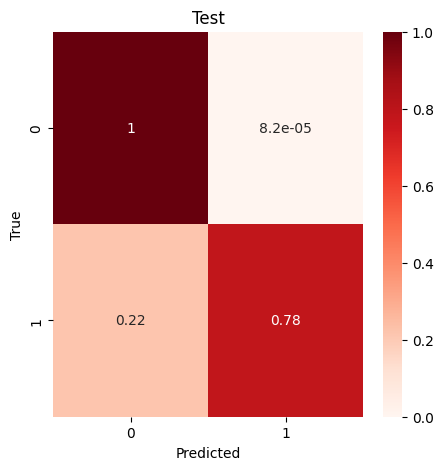

In [124]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


preds_test = model.predict(X_test)
cm_train = confusion_matrix(y_test, preds_test).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(5, 5))
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test")